<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/GSA_from%20VTI_to_isotropic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GSA isotropic

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

### Нотация Фойта - переход к матричной записи

In [2]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.empty((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

### Input data

In [3]:
# M_C11 = K_matrix + 4/3*Mu_matrix
# M_C44 = Mu_matrix
# M_C12 = M_C11 - 2*M_C44

M_C11 = 80
M_C44 = 36
M_C12 = M_C11 - 2*M_C44


C_mtrx = np.zeros((6,6))
C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

C_mtrx = mat2tens(C_mtrx, compl=False)
C_c = C_mtrx


# k, mu = K_air, Mu_air
k, mu = 2.25, 10**-6

lambda_ = k - 2 * mu / 3
c11 = lambda_ + 2 * mu
c12 = lambda_
c44 = mu

Fl_C11 = c11
Fl_C12 = c12
Fl_C44 = (Fl_C11 - Fl_C12)*0.5

C_fl = np.zeros((6, 6))
C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

C_fl = mat2tens(C_fl, compl=False)

### Tensor $g_{ijkl}$ calculation

In [7]:
pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

### From laboratory system (VTI) to isotropic

In [4]:
def izotr(c):

  pi = np.pi
  c_iz = np.zeros((3, 3, 3, 3))

  c11 = c[0, 0, 0, 0]
  c22 = c[1, 1, 1, 1]
  c33 = c[2, 2, 2, 2]
  c12 = c[0, 0, 1, 1]
  c13 = c[0, 0, 2, 2]
  c23 = c[1, 1, 2, 2]
  c44 = c[1, 2, 1, 2]
  c55 = c[0, 2, 0, 2]
  c66 = c[0, 1, 0, 1]

  t1 = 0.3141593E1**2
  t20 = 32.E0/15.E0*c44*t1 + 8.E0/5.E0*c22*t1 + 16.E0/15.E0*c23*t1 + 32.E0/15.E0*c55*t1 + 8.E0/5.E0*c11*t1 + 32.E0/15.E0*c66*t1 + 16.E0/15.E0*c13*t1 + 16.E0/15.E0*c12*t1 + 8.E0/5.E0*c33*t1
  c_iz[0, 0, 0, 0] = t20 / (8 * pi * pi)

  t20 = 32.E0/15.E0*c12*t1 + 8.E0/15.E0*c11*t1 + 8.E0/15.E0*c22*t1 - 16.E0/15.E0*c66*t1 + 32.E0/15.E0*c13*t1 + 32.E0/15.E0*c23*t1 - 16.E0/15.E0*c44*t1 + 8.E0/15.E0*c33*t1 - 16.E0/15.E0*c55*t1
  c_iz[0, 0, 1, 1] = t20 / (8 * pi * pi)
  c_iz[1, 1, 0, 0] = c_iz[0, 0, 1, 1]

  t20 = -8.E0/15.E0*c12*t1 + 8.E0/15.E0*c22*t1 + 8.E0/5.E0*c44*t1 + 8.E0/5.E0*c55*t1 + 8.E0/15.E0*c11*t1 + 8.E0/5.E0*c66*t1 - 8.E0/15.E0*c13*t1 - 8.E0/15.E0*c23*t1 + 8.E0/15.E0*c33*t1
  c_iz[0, 2, 0, 2] = t20 / (8 * pi * pi)

  c_iz[1, 1, 1, 1] = c_iz[0, 0, 0, 0]
  c_iz[2, 2, 2, 2] = c_iz[0, 0, 0, 0]
  c_iz[0, 0, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[1, 1, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 0, 0] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 1, 1] = c_iz[0, 0, 1, 1]
  c_iz[0, 2, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 0, 2] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 2, 1] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 2, 1] = c_iz[0, 2, 0, 2]

  return c_iz

In [11]:
def effective_from_VTI_to_istrop(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  num_fl_rotated = izotr(mat2tens(num_fl, compl=False))
  ### -----------


  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*tens2mat(num_fl_rotated, compl=False))
  # print(f'1st brackets (GPa)')
  # print(np.round(rslt_num, 3))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity) # matrix shape

  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  # print('B rotated isotropic') #переход в тензор с учетом размерности с использованием тензора g
  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ result_fl, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b) # tensor shape

  aa = mat2tens(np.linalg.inv(g_matrix), compl=False)
  bb = tens2mat(np.einsum('ijmn,nmkl->ijkl', aa, B), compl=False)

  result_fl_rotated = g_matrix @ bb
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl_rotated)
  # print(f'2nd brackets (1/GPa)')
  # print(np.round(rslt_dnmntr, 3))

        ### Effective matrix Cij in laboratory system
  C_eff= rslt_num @ rslt_dnmntr
  # print(f'Result in laboratory system')
  print(np.round(C_eff, 3))


  return  C_eff

### Sensetivity study

In [14]:
c11, c12, c44 = [], [], []

porosity = np.arange(0, 1.1, 0.1)

g_matrix, g_inclusion = tensor_g(C_c, [1,1,1]), tensor_g(C_c, [10,10,1])

for i in porosity:
  eff = effective_from_VTI_to_istrop(g_matrix, g_inclusion, C_mtrx, C_fl, C_c, porosity=i)
  c11.append(eff[0,0])
  c12.append(eff[0,2])
  c44.append(eff[3,3])

B rotated isotropic
[[80.  8.  8. -0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80. -0. -0.  0.]
 [-0. -0.  0. 36.  0.  0.]
 [ 0. -0. -0.  0. 36.  0.]
 [ 0.  0. -0. -0.  0. 36.]]
B rotated isotropic
[[54.686  8.228  8.228  0.    -0.     0.   ]
 [ 8.228 54.686  8.228  0.    -0.     0.   ]
 [ 8.228  8.228 54.686 -0.     0.    -0.   ]
 [-0.     0.     0.    23.229 -0.    -0.   ]
 [ 0.    -0.     0.     0.    23.229  0.   ]
 [-0.    -0.     0.     0.     0.    23.229]]
B rotated isotropic
[[39.741  7.64   7.64   0.    -0.     0.   ]
 [ 7.64  39.741  7.64   0.    -0.     0.   ]
 [ 7.64   7.64  39.741 -0.     0.    -0.   ]
 [-0.     0.     0.    16.05  -0.    -0.   ]
 [ 0.    -0.     0.     0.    16.05   0.   ]
 [-0.    -0.     0.     0.     0.    16.05 ]]
B rotated isotropic
[[29.842  6.94   6.94   0.    -0.     0.   ]
 [ 6.94  29.842  6.94   0.    -0.     0.   ]
 [ 6.94   6.94  29.842  0.    -0.     0.   ]
 [-0.     0.    -0.    11.451 -0.    -0.   ]
 [-0.    -0.     0.     0.    11.45

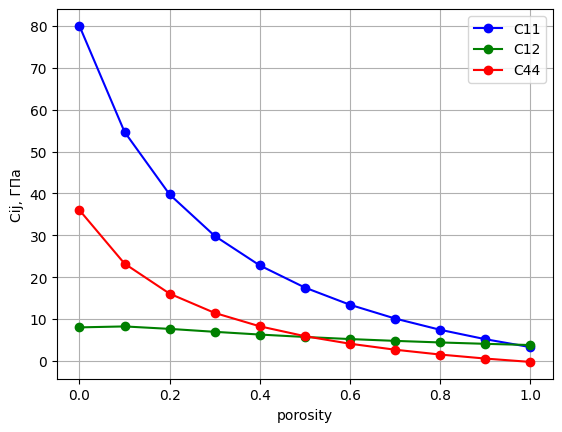

In [15]:
x = porosity

plt.plot(x, c11, label='C11', marker='o', color='blue')
plt.plot(x, c12, label='C12', marker='o', color='green')
plt.plot(x, c44, label='C44', marker='o', color='red')

# plt.xscale("log")
plt.xlabel('porosity')
plt.ylabel('Cij, ГПа')
# plt.title ('AR fluid')

plt.grid()
plt.legend()

### Velocity calculation (Vp, Vs)

In [16]:
density = 2.572247

for i, j in zip(c11, c44):
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

Vp 5.576846087743359 Vs 3.7410620856743724
Vp 4.610845734268169 Vs 3.0050932310524403
Vp 3.930643939467413 Vs 2.4979628069742135
Vp 3.406077241882495 Vs 2.109888694072226
Vp 2.9765348128886076 Vs 1.7910963134163125
Vp 2.608789787480354 Vs 1.5143003673841575
Vp 2.282270709118211 Vs 1.2616547144964128
Vp 1.9826914978876915 Vs 1.018357490613615
Vp 1.6986523208517785 Vs 0.7663685340017353
Vp 1.41906676149301 Vs 0.4640575302385428
Vp 1.1295583641940112 Vs nan


<ipython-input-16-df976d8dcc71>:4: RuntimeWarning: invalid value encountered in sqrt
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))


In [17]:
c11, c12, c44 = [], [], []

ar = [1000, 100, 10, 1]

porosity = 0.1
for i in ar:
  g_inclusion = tensor_g(C_c, [i,i,1])
  eff = effective_from_VTI_to_istrop(g_matrix, g_inclusion, C_mtrx, C_fl, C_c, porosity)
  c11.append(eff[0,0])
  c12.append(eff[0,2])
  c44.append(eff[3,3])

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


B rotated isotropic
[[17.443 14.959 14.959  0.    -0.    -0.   ]
 [14.959 17.443 14.959  0.    -0.    -0.   ]
 [14.959 14.959 17.443  0.    -0.    -0.   ]
 [ 0.     0.     0.     1.242 -0.    -0.   ]
 [-0.    -0.    -0.     0.     1.242  0.   ]
 [-0.    -0.    -0.     0.    -0.     1.242]]
B rotated isotropic
[[28.418 11.566 11.566  0.    -0.     0.   ]
 [11.566 28.418 11.566  0.    -0.     0.   ]
 [11.566 11.566 28.418  0.    -0.     0.   ]
 [-0.     0.    -0.     8.426 -0.    -0.   ]
 [ 0.     0.     0.    -0.     8.426 -0.   ]
 [ 0.    -0.     0.     0.    -0.     8.426]]
B rotated isotropic
[[54.686  8.228  8.228  0.    -0.     0.   ]
 [ 8.228 54.686  8.228  0.    -0.     0.   ]
 [ 8.228  8.228 54.686 -0.     0.    -0.   ]
 [-0.     0.     0.    23.229 -0.    -0.   ]
 [ 0.    -0.     0.     0.    23.229  0.   ]
 [-0.    -0.     0.     0.     0.    23.229]]
B rotated isotropic
[[66.506  8.04   8.04   0.    -0.     0.   ]
 [ 8.04  66.506  8.04   0.    -0.    -0.   ]
 [ 8.04   8.04  6

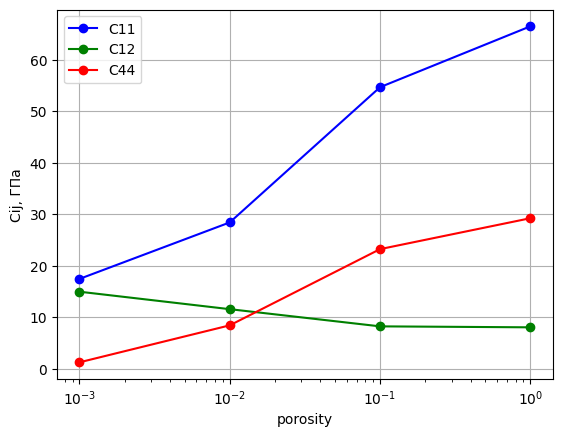

In [19]:
x = [1/1000, 1/100, 1/10, 1]

plt.plot(x, c11, label='C11', marker='o', color='blue')
plt.plot(x, c12, label='C12', marker='o', color='green')
plt.plot(x, c44, label='C44', marker='o', color='red')

plt.xscale("log")
plt.xlabel('porosity')
plt.ylabel('Cij, ГПа')
# plt.title ('AR fluid')

plt.grid()
plt.legend()